In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/yale-face-database/subject05.surprised
/kaggle/input/yale-face-database/subject09.normal
/kaggle/input/yale-face-database/subject04.rightlight
/kaggle/input/yale-face-database/subject03.leftlight
/kaggle/input/yale-face-database/subject07.glasses
/kaggle/input/yale-face-database/subject03.normal
/kaggle/input/yale-face-database/subject11.rightlight
/kaggle/input/yale-face-database/subject02.surprised
/kaggle/input/yale-face-database/subject14.surprised
/kaggle/input/yale-face-database/subject12.centerlight
/kaggle/input/yale-face-database/subject01.sad
/kaggle/input/yale-face-database/subject09.glasses
/kaggle/input/yale-face-database/subject01.rightlight
/kaggle/input/yale-face-database/subject03.noglasses
/kaggle/input/yale-face-database/subject06.noglasses
/kaggle/input/yale-face-database/subject09.happy
/kaggle/input/yale-face-database/subject03.centerlight
/kaggle/input/yale-face-database/subject12.surprised
/kaggle/input/yale-face-database/subject15.surprised
/kaggl

## Imports Libraries:

In [3]:
import matplotlib.pyplot as plt
import os
from PIL import Image 
from math import pow

## Retreiving Files

In [36]:
dir = "/kaggle/input/yale-face-database/data"

In [37]:
def list_files(dir, contains):
    return list(f for f in os.listdir(dir) if contains in f)

In [42]:
files = list_files(dir, 'subject01')
print(files)

['subject01.sad', 'subject01.rightlight', 'subject01.glasses', 'subject01.centerlight', 'subject01.normal', 'subject01.noglasses', 'subject01.happy', 'subject01.surprised', 'subject01.leftlight', 'subject01.wink', 'subject01.sleepy']


The task is to develop a system that can accurately identify the subject in any given image. For example, if an image of subject14 is fed under any condition (like subject14.surprised), the system should correctly identify it as subject14.

## Opening an Image

In [5]:
image_path = "/kaggle/input/yale-face-database/subject01.happy"

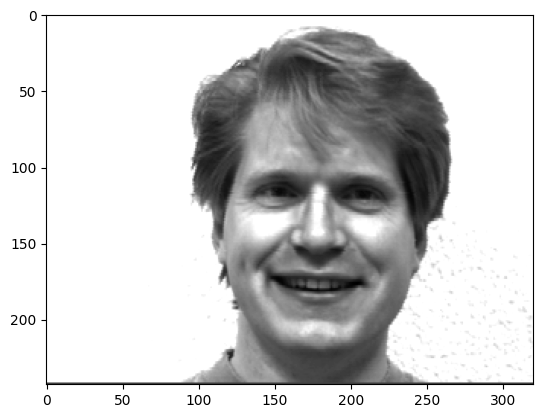

In [7]:
with Image.open(image_path) as im:
    plt.imshow(im,cmap="gray")

In [23]:
img_ndarray = np.asarray(im)

## Feature Extraction

### Step1: Padding

In [22]:
def padding(img):
    (h,w) = (img.shape)
    p = np.zeros((h+2,w+2)) 
    for i in range(0,h):
        for j in range(0,w):
            p[i+1][j+1]=img[i][j]
    return p

In [23]:
padded_im = padding(img_ndarray)

In [24]:
img_ndarray

array([[130, 130, 130, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 249, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [ 68,  68,  68, ...,  68,  68,  68]], dtype=uint8)

In [25]:
padded_im

array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0., 130., 130., ..., 255., 255.,   0.],
       [  0., 255., 255., ..., 255., 255.,   0.],
       ...,
       [  0., 255., 255., ..., 255., 255.,   0.],
       [  0.,  68.,  68., ...,  68.,  68.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

In [26]:
print(f"Shape of orginal image {img_ndarray.shape} \nShape of padded array {padded_im.shape}")

Shape of orginal image (243, 320) 
Shape of padded array (245, 322)


### Step 2: Extracting Local Binary Patterns

In [33]:
def LBP(padded_img,img_ndarray):
    (ih,iw) = img_ndarray.shape
    lbp_image = np.zeros((ih,iw))
    neighborhood = [(-1, -1), (-1, 0), (-1, 1), (0, 1), (1, 1), (1, 0), (1, -1),(0,-1)]
    total = 0
    k = 0
    (pw,ph) = padded_img.shape
    for i in range (1, ph-1):
        for j in range (1,pw-1):
            center = padded_img[i][j]
            k=0
            for x, y in neighborhood:
                neighbor_pixel = padded_img[i + x, j + y]
                
                if (center > neighbor_pixel):
                    binary_code = 1
                else:
                    binary_code = 0
                    
                total += int(pow(2,k)) * binary_code
                k+=1
            

            lbp_image[i - 1, j - 1] = total
            
    return lbp_image
            

In [36]:
lbp = LBP(padded_im,img_ndarray)

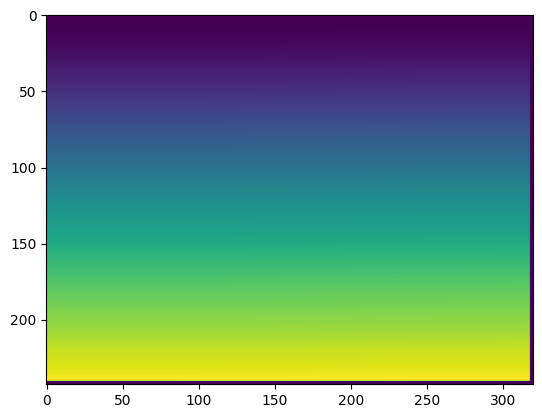

In [37]:
padded_image = Image.fromarray(lbp)
plt.imshow(lbp)

In [35]:
def LBP(padded_img, img_ndarray):
    (ih, iw) = img_ndarray.shape
    lbp_image = np.zeros((ih, iw))
    neighborhood = [(-1, -1), (-1, 0), (-1, 1), (0, 1), (1, 1), (1, 0), (1, -1), (0, -1)]
    total = 0
    k = 0
    (pw, ph) = padded_img.shape
    for i in range(1, ih - 1):
        for j in range(1, iw - 1):
            center = padded_img[i][j]
            k = 0
            for x, y in neighborhood:
                neighbor_pixel = padded_img[i + x, j + y]

                if center > neighbor_pixel:
                    binary_code = 1
                else:
                    binary_code = 0

                total += int(pow(2, k)) * binary_code
                k += 1

            lbp_image[i - 1, j - 1] = total

    return lbp_image